In [27]:
import tensorflow as tf

In [ ]:
from google.colab import files
uploaded = files.upload()


In [3]:
import zipfile

with zipfile.ZipFile('Test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/mydata')



In [4]:
import os
os.listdir('/content/mydata')

['Test']

In [5]:
import os
from glob import glob

image_dir = "/content/mydata"  # 압축 해제한 폴더 경로
image_paths = glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True)  # png도 가능
print(f"{len(image_paths)}개의 이미지 발견")

150개의 이미지 발견


In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 이미지 크기 통일
    transforms.ToTensor(),  # Tensor로 변환
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화
])


In [11]:
test_dataset = datasets.ImageFolder(root="/content/mydata", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("클래스:", test_dataset.classes)


클래스: ['Test']


Labels: ['Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test']


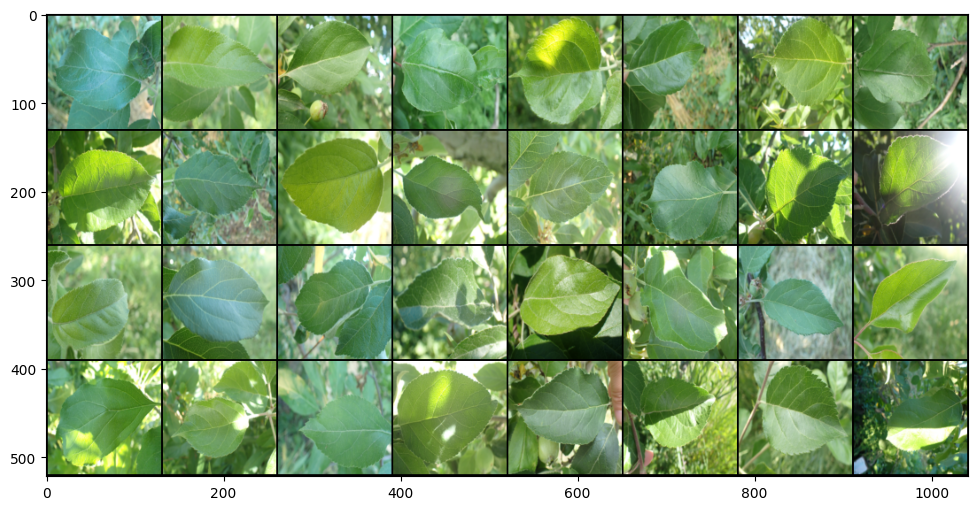

In [12]:
from torchvision.utils import make_grid
import numpy as np

def show_images(images, labels):
    images = images * 0.5 + 0.5  # unnormalize
    npimg = make_grid(images.cpu()).numpy()
    plt.figure(figsize=(18, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    print("Labels:", [test_dataset.classes[l] for l in labels])

images, labels = next(iter(test_loader))
show_images(images, labels)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder("/content/mydata", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(train_dataset.classes)  # ['health', 'powdry', 'rusts'] 등


['Test']


In [16]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 128 * 128, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 3)  # 클래스 3개

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = SimpleNN().to(device)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {100*correct/total:.2f}%")


Epoch 1/5 | Loss: 0.2382 | Accuracy: 80.00%
Epoch 2/5 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 3/5 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 4/5 | Loss: 0.0000 | Accuracy: 100.00%
Epoch 5/5 | Loss: 0.0000 | Accuracy: 100.00%


In [20]:
test_dataset = datasets.ImageFolder("/content/mydata", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [26]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")
# 모델 평가 정확도

Test Accuracy: 100.00%


Predicted: ['Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test', 'Test']


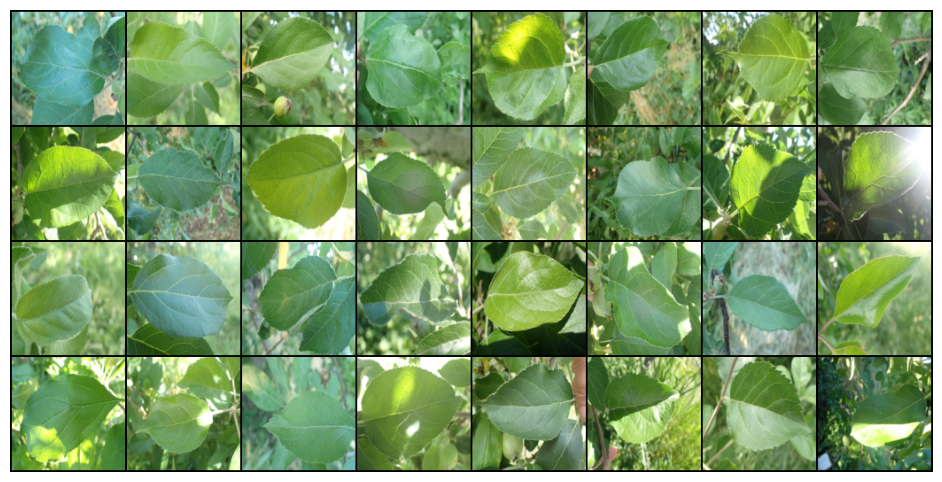

In [21]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, labels, preds=None):
    images = images * 0.5 + 0.5  # unnormalize
    npimg = make_grid(images.cpu()).numpy()
    plt.figure(figsize=(18, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    if preds is not None:
        print("Predicted:", [test_dataset.classes[p] for p in preds])
    else:
        print("Labels:", [test_dataset.classes[l] for l in labels])

# 예시 이미지 1배치 출력
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)
show_images(images, labels, preds)


In [25]:
# 모델 저장
torch.save(model.state_dict(), "/content/simple_nn_model.pth")
